In [13]:
#!pip install kaggle
#!pip install missigno
import os
import networkx as nx
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as msno
import regex as re

Data from: https://www.kaggle.com/leomauro/smmnet

# Datenbeschaffung & Aufbereitung

## Setup kaggle api

In [2]:
# Create .kaggle path in user dir if not exists
if not os.path.exists(str(Path.home())+"\.kaggle"):
    os.makedirs(str(Path.home())+"\.kaggle")

Go to www.<span>kaggle.<span>com/**your_username**/account and download a new api-token. 
After downloading the json file needs to be put into the C:\Users\\**username**\\.kaggle directory.

## Download dataset

In [3]:
# Check if folder already exists
if not os.path.isdir('./data'):
    
    # if not create data folder
    os.makedirs('./data') 
    
    # download csv's
    !kaggle datasets download -d "leomauro/smmnet" -p "./data"

## Unzip files

In [4]:
file_list = ["clears.csv","course-meta.csv","courses.csv","likes.csv","players.csv","plays.csv","records.csv"]
files_exist = []

# Check if all csv's exist
for file in file_list:
    files_exist.append(os.path.isfile("./data/" + file))
    
# if not create csv's
if not all(files_exist):
    with zipfile.ZipFile("./data/smmnet.zip", 'r') as zip_ref:
        zip_ref.extractall("./data") 

## Import files as Pandas DataFrame

In [6]:
clears = pd.read_csv("./data/clears.csv", delimiter = "\t")
course_meta = pd.read_csv("./data/course-meta.csv", delimiter = "\t") # index_col=["id","firstClear"]
courses = pd.read_csv("./data/courses.csv", delimiter = "\t")
likes = pd.read_csv("./data/likes.csv", delimiter = "\t")
players = pd.read_csv("./data/players.csv", delimiter = "\t")
plays = pd.read_csv("./data/plays.csv", delimiter = "\t")
records = pd.read_csv("./data/records.csv", delimiter = "\t")

dfs = {"clears":clears, "course_meta":course_meta, "courses":courses, "likes":likes, "players":players,"plays":plays, "records":records}

In [9]:
clears.head()

,catch,id,player
0,2018-02-23 15:22:44.015,0000-0000-0353-3D35,darter60k
1,2018-02-23 15:22:44.015,0000-0000-0353-3D35,davidchofis
2,2018-02-23 15:22:44.015,0000-0000-0353-3D35,fabioviana
3,2018-02-23 15:22:44.015,0000-0000-0353-3D35,groebenzell
4,2018-02-23 15:22:44.015,0000-0000-0353-3D35,igatake0229


# Data Validation
In this Kaggle Dataset, we provide over 115 thousand games maps created on Super Mario Maker with over 880 thousand players which performed over 7 millions of interactions on these maps. By interactions, this means that a player can: (1) create a game map; (2) play a map created by other players; if a player completes the challenge of the game map, he/she (3) "cleared" the map; also can be the (4) first clear; beat the (5) time record of a map; (6) at any time, the player can "like" a game map. Note, this dataset present temporal changes over time for each game map by a period of three months.

The data was extracted from supermariomakerbookmark.nintendo.net, the game website. Now it is publicly to everyone play, explore and research. This dataset serves as a good base for learning models, including, but not limited to, Player Modeling (e.g., player experience), Data Mining (e.g., prediction, and find patterns), and Social Network Analysis (e.g., community detection, link prediction, ranking).

In [11]:
# add correct dtype to timestamps
for name, df in dfs.items():
    if "catch" in df.columns:
        df.catch = pd.to_datetime(df.catch)
    elif "creation" in df.columns:
        df.creation = pd.to_datetime(df.creation)

In [58]:
# multiple asserts
assert len(players) >= 880_000, "Number of players is less than expected"
assert len(courses) >= 115_000, "Number of courses is less than expected"
assert (course_meta.attempts >= course_meta.clears).all(), "At least one occurance of clears < attempts detected"
assert len(players) == len(players.id.unique()), "Player id not unique"
assert len(courses) == len(courses.id.unique()), "Course id not unique"

for name, df in dfs.items():
    # test for legitimate timestamps
    if "catch" in df.columns:
        # catch needs to be between 2017-11-16 and 2018-04-10
        assert df.catch.between("2017-11-15","2018-04-11").all(), f"Detected catch timestamp out of range '2017-11-16' - '2018-04-10' in df {name}"
    elif "creation" in df.columns:
        # catch needs to be between 2017-11-16 and 2018-04-10
        assert (df.creation <= "2018-04-10").all(), f"Detected creation date more recent than 2018-04-10 in df {name}"
    
    # test for negative numbers in numeric variables
    numerics = ['int64', 'float64']
    num_cols = df.select_dtypes(include=numerics).columns
    for col in num_cols:
        assert (df[col].values >= 0).all(), f"At least one occurance of negative values detected in df {name}"

    # test if id is in allowed format
    r = re.compile("[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}")
    if "id" in df.columns and name != "players":
        assert df.id.str.fullmatch("[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}-[A-Z|0-9]{4}").all(), f"At least one id in wrong format detected in df {name}"
        
# check if clears == 0 than firstClear == NaN
assert course_meta[course_meta.clears == 0, firstClear.isna()] 

In [69]:
course_meta[(course_meta.clears != 0) & (course_meta.firstClear.isna())]

,catch,id,firstClear,tag,stars,players,tweets,clears,attempts,clearRate
265,2017-11-16 14:54:45.863,2258-0000-0301-0B14,NaN,NaN,2,44,0,34,93,36.55
816,2017-11-16 15:13:36.300,5891-0000-0320-87E0,NaN,NaN,2,19,0,6,62,9.67
4132,2017-11-21 14:32:41.954,ABC8-0000-0350-91D7,NaN,NaN,1,11,0,8,41,19.51
6138,2017-12-15 16:08:43.339,C123-0000-030F-AEE3,NaN,NaN,27,253,0,18,2463,0.73
6648,2017-12-15 23:27:56.916,C123-0000-030F-AEE3,NaN,NaN,27,254,0,18,2465,0.73
...,...,...,...,...,...,...,...,...,...,...
290183,2018-03-13 22:01:33.607,3555-0000-0337-E56F,NaN,NaN,4,15,0,9,77,11.68
290939,2018-04-10 11:04:25.834,3450-0000-0329-1F72,NaN,NaN,7,57,0,52,87,59.77
291252,2018-04-10 11:08:13.726,0D18-0000-035B-04B7,NaN,NaN,5,32,0,27,42,64.28
291329,2018-04-10 11:09:59.866,0D45-0000-0336-B15E,NaN,NaN,4,50,0,47,65,72.30


In [26]:
for name, df in dfs.items():
    if df.isnull().sum().sum() > 0:
        print(f"{name}:")
        print(df.isnull().sum())
        print("\n")

course_meta:
catch              0
id                 0
firstClear      4127
tag           257922
stars              0
players            0
tweets             0
clears             0
attempts           0
clearRate          0
dtype: int64


courses:
id             0
difficulty     0
gameStyle      0
maker         76
title          3
thumbnail      0
image          0
creation       0
dtype: int64


players:
id        0
image     0
flag      0
name     10
dtype: int64




# EDA

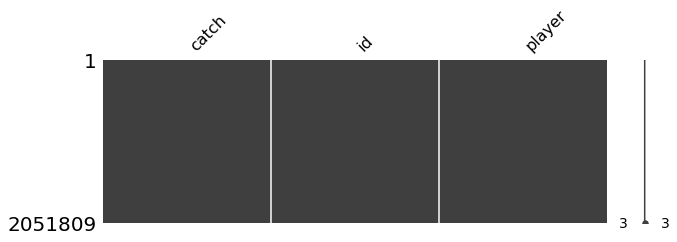

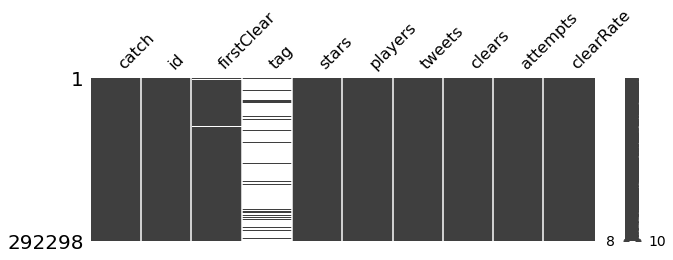

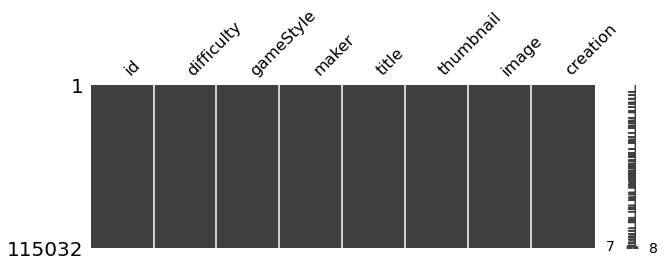

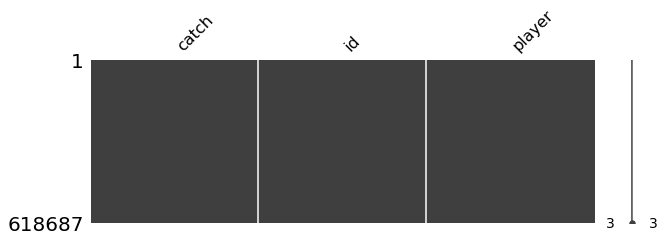

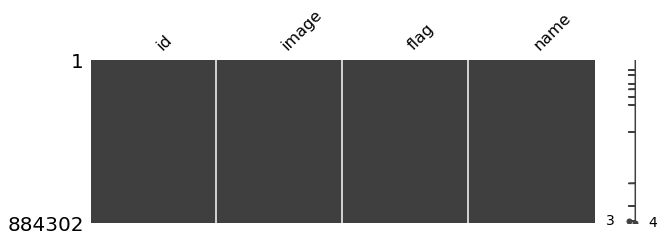

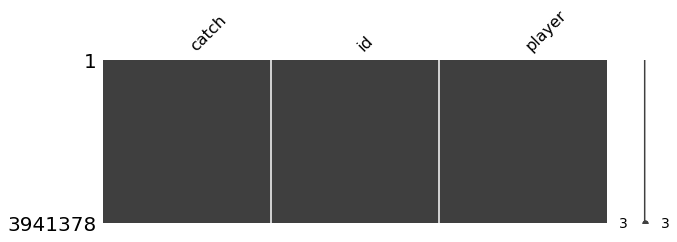

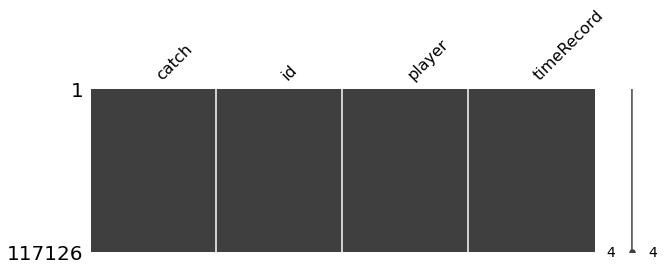

In [15]:
for name, df in dfs.items():
    msno.matrix(df, figsize=(8,2))
    plt.show()

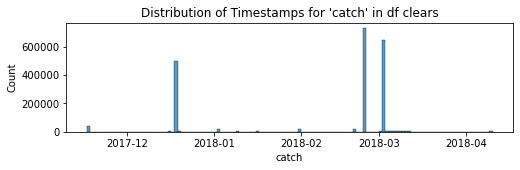

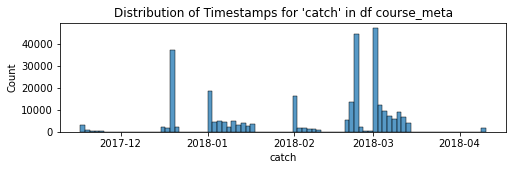

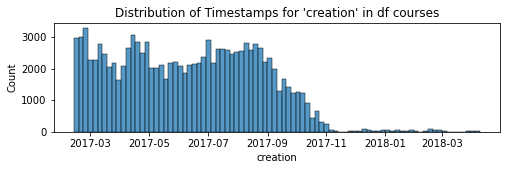

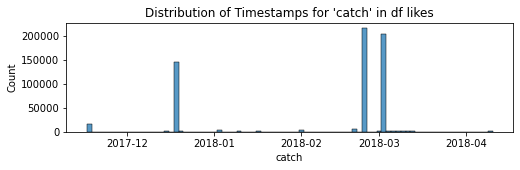

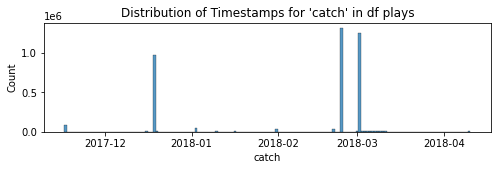

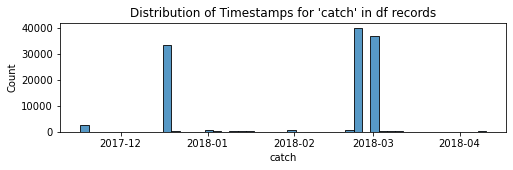

In [19]:
for name, df in dfs.items():
    if "catch" in df.columns:
        col = "catch"
    elif "creation" in df.columns:
        col = "creation"
    else:
        continue
    plt.figure(figsize=(8,2))
    sns.histplot(df[col]).set_title(f"Distribution of Timestamps for '{col}' in df {name}")
    plt.show()

# Social Network Analysis